<a href="https://colab.research.google.com/github/Osmanov-Bairam/MKB_BANK/blob/main/Model_MKB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Define the problem

Банковская гарантия — соглашение, по которому банк обязан выплатить долг клиента, если тот не выполнил своих обязательств. Выдача гарантий банком происходит после одобрения клиентской заявки.


Задача — построить аппликационную модель оценки вероятности предъявления по гарантии, чтобы минимизировать потери от кредитного риска. В качестве предикторов для моделирования используются анкетные данные клиента и его финансовые показатели.

# 2) Import libraries

Imort and install all neccessery libraries

In [2]:
# !pip install scikit-learn-intelex

In [3]:
# !pip install catboost

In [4]:
# !pip install shap

In [ ]:
# load packages
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
pandas version: 1.1.5
matplotlib version: 3.2.2
NumPy version: 1.19.5
SciPy version: 1.4.1
IPython version: 5.5.0
scikit-learn version: 1.0.2
-------------------------


In [ ]:
# other libraries
import random
import time
import os
import requests
import collections
import pickle
from tqdm import tqdm

In [ ]:
# Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

# Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import Pipeline

# Uncommon Model Algorithms
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from catboost import Pool

# to split the datasets
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# from pandas.tools.plotting import scatter_matrix
import missingno as msno


In [ ]:
# from feature-engine

! pip install feature-engine

     |████████████████████████████████| 205 kB 4.9 MB/s 
     |████████████████████████████████| 9.8 MB 53.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    RandomSampleImputer,
    EndTailImputer,
    CategoricalImputer
)

# 3) Presetting

In [ ]:
# To plot pretty figures

#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
# Connect to google drive to get access to data

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Where to save the figures

IMAGES_PATH = "/content/gdrive/MyDrive/Projects/MKB_Bank/Plots"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
path_pikcle = "/content/gdrive/MyDrive/Projects/MKB_Bank/Pickles/Pickles"

# 4) Gather & Import the data

In [ ]:
# load dataset from google drive folders

path_data = "/content/gdrive/MyDrive/Projects/MKB_Bank/Dataset/Bank_Data/train_dataset_hackathon_mkb.csv"
data = pd.read_csv(path_data,  sep=';', encoding ='cp1251')

In [ ]:
# load description about features

path_decrib = "/content/gdrive/MyDrive/Projects/MKB_Bank/Dataset/Bank_Data/data_description.xlsx"
describ = pd.read_excel(path_decrib)

# 5) Meet and Greet Data

Let's familiarize ourselves with data

In [ ]:
data.head(3)

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,...,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,331298000.0,138000.0,1.960896e+09,10007000.0,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,...,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,553000.0,37000.0,9.073600e+07,100000.0,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,...,1.0,1.0,36.00.2,6.0,2762852.0,1.0,794.0,3.0,21.0,5408695.0,39.0,882647.0,4.0,1.0,0.0,1.0,1.0,1174998.0,2.0,0.0,2.0,2.0,2738217.0,38.0,0.0,38.0,39.0,4209963.0,169.0,0.0,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17891 entries, 0 to 17890
Columns: 124 entries, id_contract to CITIZENSHIP_NAME
dtypes: float64(108), int64(4), object(12)
memory usage: 16.9+ MB


In [ ]:
# data balance

data["TARGET"].value_counts()

0    10502
1     7389
Name: TARGET, dtype: int64

We observe some imbalance in distribution of our classes which means we need take it into account when splitting data into train and test set.

# 6) Split thee data

data1 - will be used for training and validation

data_val - will be used for final evaluation 



In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["TARGET"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

In [ ]:
data1 = strat_train_set.copy(deep = True).sort_values(by=['SIGN_DATE','id_client'])
data_val = strat_test_set.copy(deep = True).sort_values(by=['SIGN_DATE','id_client'])

# 7) Research

## Research on fullness

**Let's check how many nulls we have in each column.**

---



Saving figure Fullness of columns


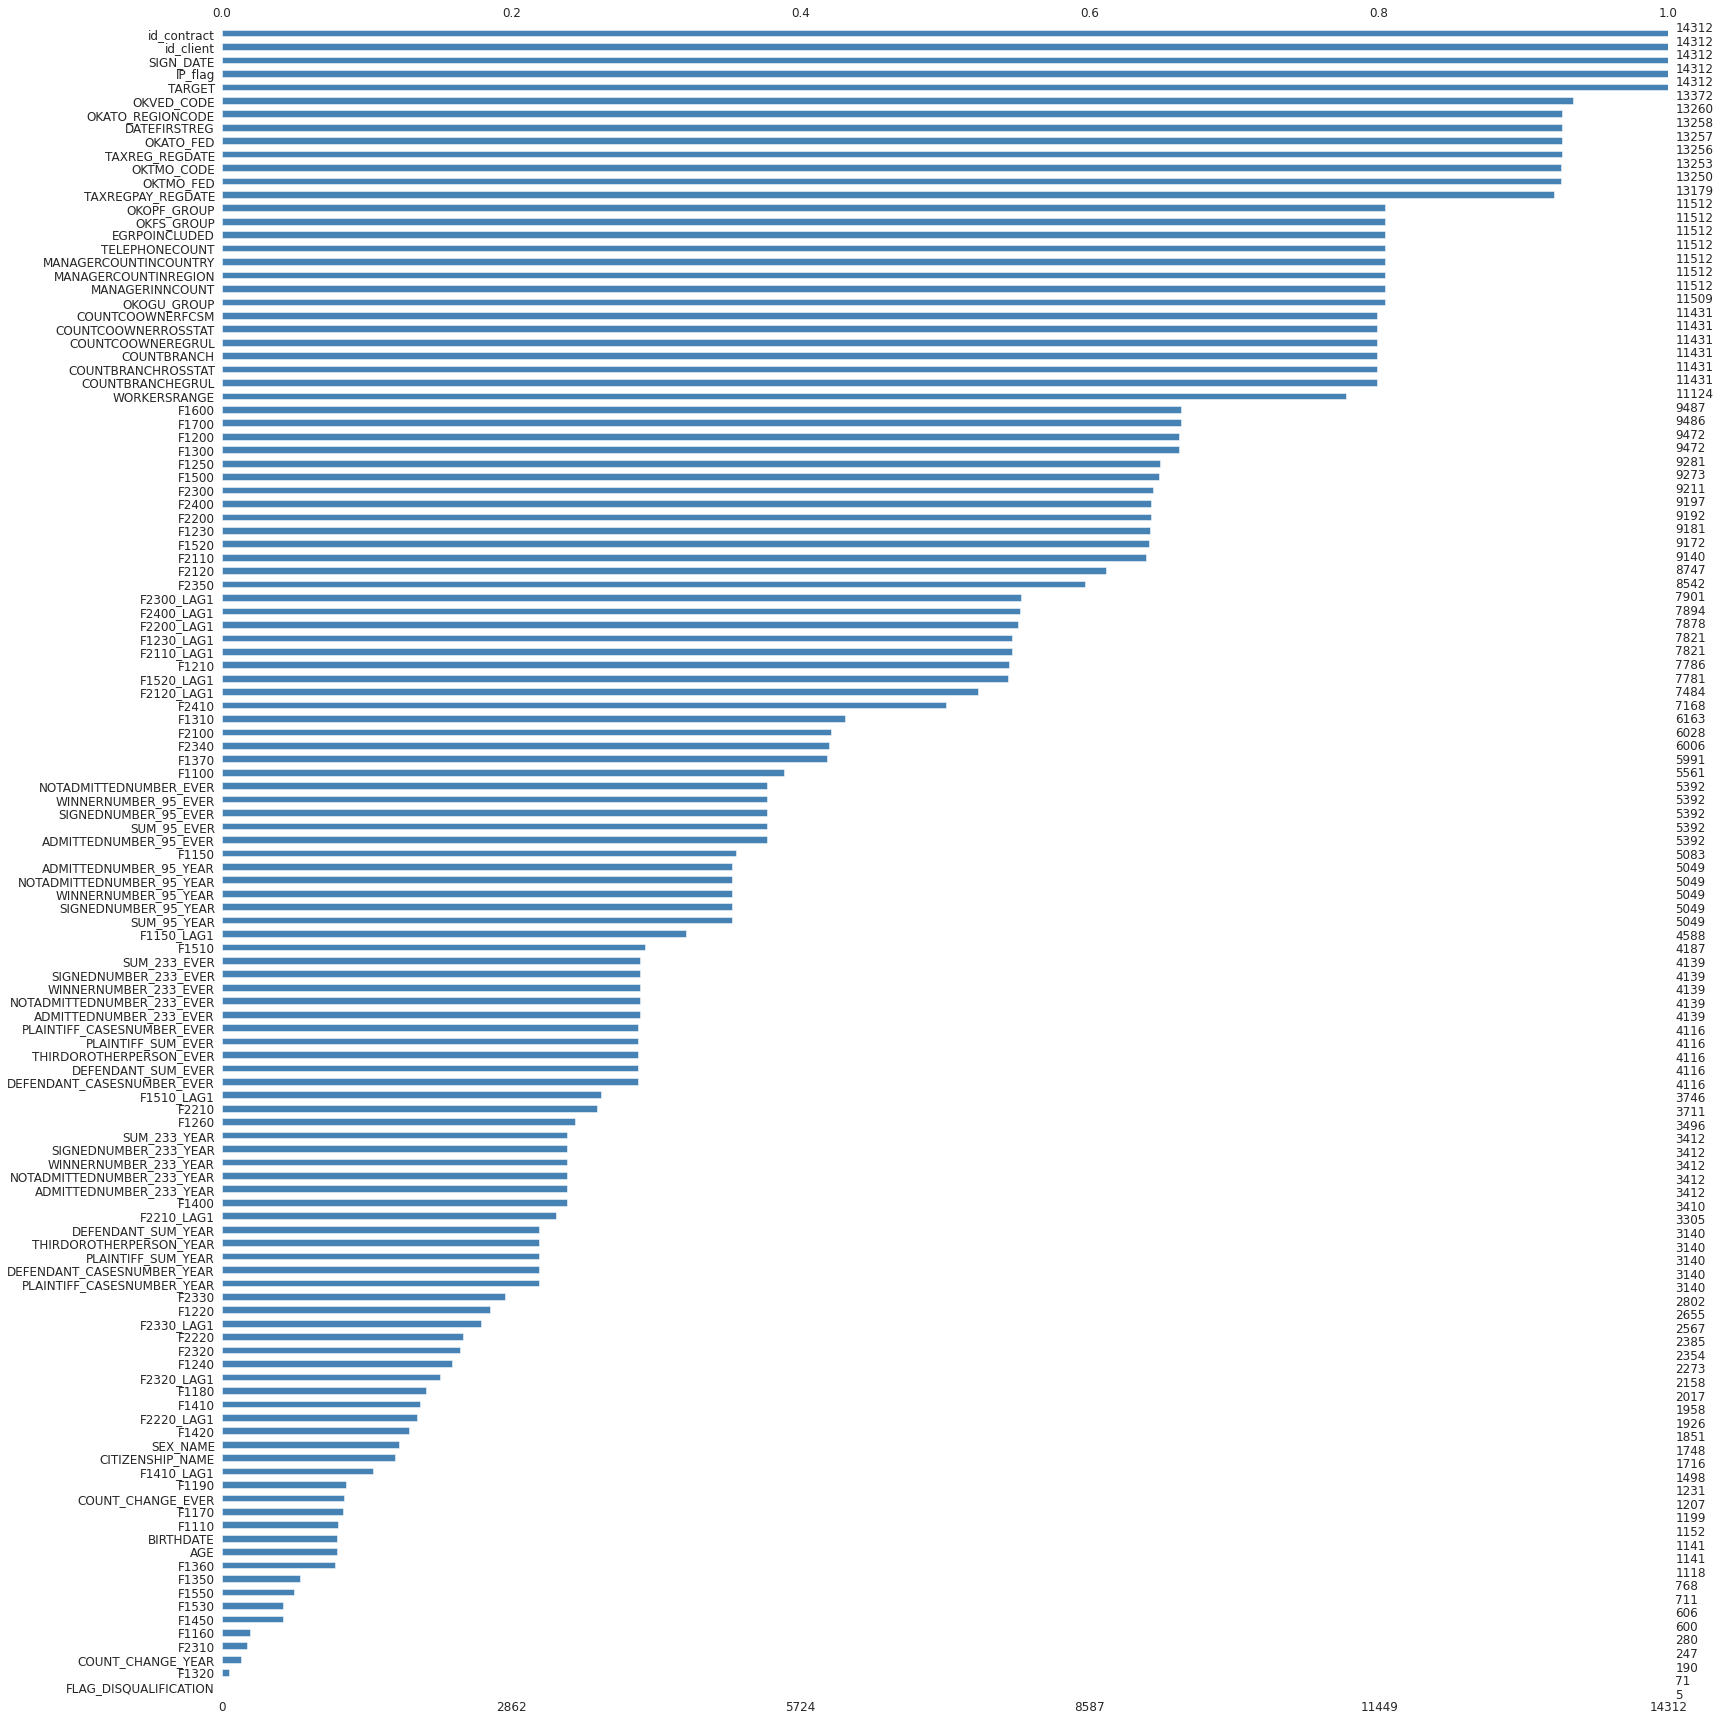

In [ ]:
# how much is null on columns level

msno.bar(data1, figsize=(24, 24), fontsize=12, color='steelblue', sort = "ascending");
save_fig("Fullness of columns")

Only IP_flag, SIGN_DATA, id_client и id_contract are filled for all clients. 


**Let's check how many permanent clients we have in out data.**

---



In [ ]:
client = (data["id_client"].value_counts() > 1).mean().round(2)*100
contract = (data["id_contract"].value_counts() > 1).mean().round(2)*100

In [ ]:
print("Percent of same clients %: ",  client)
print("Percent of same contracts %: ",  contract)

Percent of same clients %:  19.0
Percent of same contracts %:  0.0


We can umpute features for permanent clients if we will missing values in sime observations with that clients. For example, some features could be unchanged in in course of time for specific client.


**Let's check how many percentage of null values in rows.**


---



In [ ]:
def add_feature_full(data):
  for index, row in pd.notna(data).iterrows():
    data.loc[index, "Fullness"] = row.mean().round(2)

In [ ]:
add_feature_full(data1)
add_feature_full(data_val)

Saving figure Percent of rows are filled


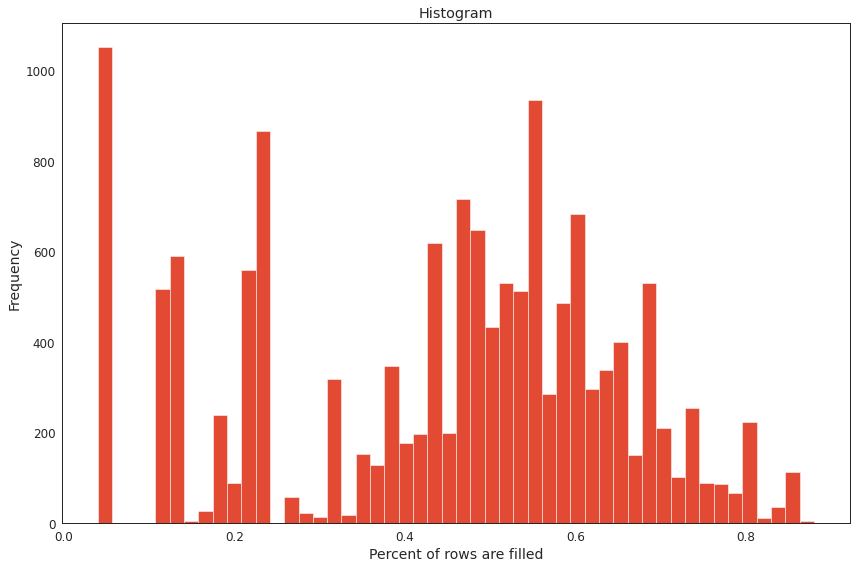

In [ ]:
ax = data1["Fullness"].plot(kind = "hist", 
                       title = "Histogram", bins = 50)
ax.set_xlabel("Percent of rows are filled");
save_fig("Percent of rows are filled")

We have some observations with almost all nulls in their features. 

## Time sequence research

In [ ]:
dates = ["TAXREG_REGDATE", "TAXREGPAY_REGDATE", "SIGN_DATE", "DATEFIRSTREG"]
data_temp_time = data1.copy()
data_temp_time[dates].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14312 entries, 3391 to 11481
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   TAXREG_REGDATE     13256 non-null  object
 1   TAXREGPAY_REGDATE  13179 non-null  object
 2   SIGN_DATE          14312 non-null  object
 3   DATEFIRSTREG       13258 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [ ]:
# change the type
for d in dates:
  data_temp_time[d] = pd.to_datetime(data[d], format='%d%b%Y:%H:%M:%S')

In [ ]:
data_temp_time[dates].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14312 entries, 3391 to 11481
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TAXREG_REGDATE     13256 non-null  datetime64[ns]
 1   TAXREGPAY_REGDATE  13179 non-null  datetime64[ns]
 2   SIGN_DATE          14312 non-null  datetime64[ns]
 3   DATEFIRSTREG       13258 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 1.2 MB


Saving figure SIGN_DATE_RESEARCH


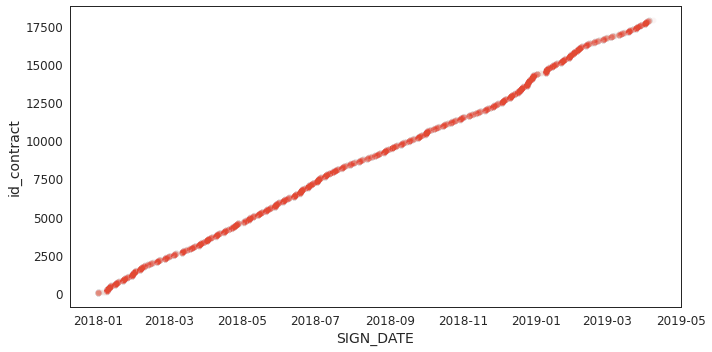

In [ ]:
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 5))
sns.scatterplot(data=data_temp_time, x="SIGN_DATE", y="id_contract", alpha=0.01)
save_fig("SIGN_DATE_RESEARCH")

We can impute missing values in "SIGN_DATE" feature by deriving avarage from left and right time.

# 8) Data Imputation

## 1) Imputation technic №1

---




Here I am going to implement fast and lazy imputation to use it as baseline in the future. In order to do that I will use End of distribution imputation technic for numerical and arbitrary value imputation technic for categorical variables.


**Numerical**

How do we select the value at the end?

-If the variable is normally distributed, we can use the mean plus or minus 3 times the standard deviation

-If the variable is skewed, we can use the IQR proximity rule

**Categotrical**

This method consists in treating missing data as an additional label or category of the variable. All the missing observations are grouped in the newly created label 'Missing'.

**Timestamp**

Mode imputation consists of replacing all occurrences of missing values (NA) within a variable by the mode, which in other words refers to the most frequent value or most frequent category.

In [ ]:
# find numerical variables
# those different from object and also excluding the target
features_numerical = [c for c in data1.columns if data1[c].dtypes!='O' and c !='TARGET']

# find timestamp variables
dates = ["TAXREG_REGDATE", "TAXREGPAY_REGDATE", "SIGN_DATE", "DATEFIRSTREG"]

# find categorical variables
# those of type 'Object' in the dataset
features_categorical =  list(set([c for c in data1.columns if data1[c].dtypes=='O']) - set(dates))

In [ ]:
pipe = Pipeline([
    ('imputer_skewed', EndTailImputer(imputation_method='iqr', tail='right',
                                      variables=features_numerical)),
                 
    ('imputer_mode', CategoricalImputer(imputation_method='frequent', variables=dates)),
                 
    ('imputer_missing', CategoricalImputer(variables=features_categorical)),
])

pipe.fit(data1)

Pipeline(steps=[('imputer_skewed',
                 EndTailImputer(imputation_method='iqr',
                                variables=['id_contract', 'id_client',
                                           'IP_flag', 'F1100', 'F1110', 'F1150',
                                           'F1160', 'F1170', 'F1180', 'F1190',
                                           'F1200', 'F1210', 'F1220', 'F1230',
                                           'F1240', 'F1250', 'F1260', 'F1300',
                                           'F1310', 'F1320', 'F1350', 'F1360',
                                           'F1370', 'F1400', 'F1410', 'F1420',
                                           'F1450', 'F1500', 'F1510', 'F1520', ...])),
                ('imputer_mode',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['TAXREG_REGDATE',
                                               'TAXREGPAY_REGDATE', 'SIGN_DATE',
                             

In [ ]:
imputed_train_v1 = pipe.transform(data1)

imputed_test_v1 = pipe.transform(data_val)

In [ ]:
imputed_list = {}

In [ ]:
imputed_list = {"imputed_train_v1" : imputed_train_v1, "imputed_test_v1" : imputed_test_v1}

## 2) Imputation technic №2

---



Random sampling imputation is in principle similar to mean / median / mode imputation, in the sense that it aims to preserve the statistical parameters of the original variable, for which data is missing.

Random sampling consist of taking a random observation from the pool of available observations of the variable, and using that randomly extracted value to fill the NA. In random sample imputation one takes as many random observations as missing values are present in the variable.

We do not know whether data are missing at random or not. It is a good idea to replace missing observations by random value AND flag those missing observations as well with a Missing Indicator. A Missing Indicator is an additional binary variable, which indicates whether the data was missing for an observation (1) or not (0).



In [ ]:
pipe = Pipeline([
    ('missing_ind', AddMissingIndicator()),

    ('imputer_random', RandomSampleImputer(random_state = 42))
])

In [ ]:
pipe.fit(data1)
imputed_train_v2 = pipe.transform(data1)
imputed_test_v2 = pipe.transform(data_val)

In [ ]:
# checking

print("Columns with missing values in train:")
[feature for feature in imputed_train_v2.columns if imputed_train_v2.isnull().any()[feature] == True]

Columns with missing values in train:


[]

In [ ]:
imputed_list["imputed_train_v2"] = imputed_train_v2
imputed_list["imputed_test_v2"] = imputed_test_v2

## 3) Imputation technic №3 (in development)

---




1.   We impute missing categorical features for clients who attend bank more than 1 time. 
2.   Impute datestamp



## Check

In [ ]:
if len(imputed_list) == 4:
  print("Everything is ok")
else:
  print("We have some problems")

Everything is ok


# 9) Feature construction

Here we will create new features manually. There is a way to do that using nueral networks automatically. But we will not consider that approach in this notebook.

## Debt features


In [ ]:
def construct_debt_features(data):

  # all debt
  data['debt'] = (data['F1410']+data['F1510'])
  # ratio
  data['debt_on_profit'] = (data['F1410']+data['F1510'])/data['F2110']
  # ratio from past
  data['debt_on_profit_LAG1'] = (data['F1410_LAG1']+data['F1510_LAG1'])/data['F2110_LAG1']
  # change absolut
  data['debt_on_profit_diff']  = data['debt_on_profit'] - data['debt_on_profit_LAG1']
  # change relative
  data['debt_on_profit_diff_ratio']  = (data['debt_on_profit'] - data['debt_on_profit_LAG1'])/data['debt_on_profit']

  print("Debt feature construction is completed")

## Arbitrage and bid features. 

In [ ]:
def construct_ratio_features(data):
  # for convinience
  data.rename(columns={'NOTADMITTEDNUMBER_EVER': 'NOTADMITTEDNUMBER_95_EVER','THIRDOROTHERPERSON_YEAR':'THIRDOROTHERPERSON_CASESNUMBER_YEAR',
                        'THIRDOROTHERPERSON_EVER':'THIRDOROTHERPERSON_CASESNUMBER_EVER'}, inplace=False)    
  # for iteration
  ever_year_info = ['PLAINTIFF_SUM','PLAINTIFF_CASESNUMBER','DEFENDANT_CASESNUMBER','DEFENDANT_SUM', 'THIRDOROTHERPERSON_CASESNUMBER',
                    'ADMITTEDNUMBER_233','NOTADMITTEDNUMBER_233','WINNERNUMBER_233', 'SIGNEDNUMBER_233','SUM_233','ADMITTEDNUMBER_95',
                    'NOTADMITTEDNUMBER_95','SIGNEDNUMBER_95', 'WINNERNUMBER_95','SUM_95','COUNT_CHANGE']

  for col in ever_year_info:
      # compare bit and arbitrage of this year with history 
      # -1 if there is no value in the history
      func_ration = lambda x: -1 if x['{}_EVER'.format(col)] == 0 else x['{}_YEAR'.format(col)]/x['{}_EVER'.format(col)]
      data['RATIO_YEAR_EVER_{}'.format(col)] = data[['{}_YEAR'.format(col), '{}_EVER'.format(col)]].apply(func_ration, axis=1)

  print("Ratio feature construction is completed")

## Arbitrage only features

In [ ]:
def construct_arbitrage_features(data):
  tender_info = ['NUMBER_233_YEAR','NUMBER_233_EVER', 'NUMBER_95_YEAR','NUMBER_95_EVER']

  data.rename(columns={'NOTADMITTEDNUMBER_EVER': 'NOTADMITTEDNUMBER_95_EVER','THIRDOROTHERPERSON_YEAR':'THIRDOROTHERPERSON_CASESNUMBER_YEAR',
                        'THIRDOROTHERPERSON_EVER':'THIRDOROTHERPERSON_CASESNUMBER_EVER'}, inplace=True)  
    
  for col in tender_info:
      # total 
      data['SUM_ADM_NOTADM_{}'.format(col)] = (data['ADMITTED{}'.format(col)] + data['NOTADMITTED{}'.format(col)] )
      
      # Percent of admitted cases
      func_ratio = lambda x: -1 if x['NOTADMITTED{}'.format(col)] + x['ADMITTED{}'.format(col)] == 0 else x['ADMITTED{}'.format(col)] / (x['NOTADMITTED{}'.format(col)]+x['ADMITTED{}'.format(col)])
      data['RATIO_ADMIT_{}'.format(col)] = data[['ADMITTED{}'.format(col), 'NOTADMITTED{}'.format(col)]].apply(func_ratio, axis=1)

      # Percent of winned cases
      func_ratio = lambda x: -1 if x['ADMITTED{}'.format(col)] == 0 else x['WINNER{}'.format(col)] / x['ADMITTED{}'.format(col)]
      data['RATIO_WIN_{}'.format(col)] = data[['WINNER{}'.format(col), 'ADMITTED{}'.format(col)]].apply(func_ratio, axis=1)
      
      # Percent of signed cases after winning
      func_ratio = lambda x: -1 if x['WINNER{}'.format(col)] == 0 else x['SIGNED{}'.format(col)] / x['WINNER{}'.format(col)]
      data['RATIO_WIN_SIG_{}'.format(col)] = data[['WINNER{}'.format(col), 'SIGNED{}'.format(col)]].apply(func_ratio, axis=1)


  judge_info = ['CASESNUMBER_YEAR', 'CASESNUMBER_EVER']
  judge_info_2 = ['SUM_EVER', 'SUM_YEAR']

  for col in judge_info:

      # total cases in arbitrage
      data['SUM_PLA_DEF_THI_{}'.format(col)] = data['PLAINTIFF_{}'.format(col)] + data['DEFENDANT_{}'.format(col)] + data['THIRDOROTHERPERSON_{}'.format(col)]

      # case ratio
      func_ration = lambda x: -1 if x['THIRDOROTHERPERSON_{}'.format(col)] == 0 else x['DEFENDANT_{}'.format(col)] /x['THIRDOROTHERPERSON_{}'.format(col)]
      data['RATIO_DEF_THI_{}'.format(col)] = data[['DEFENDANT_{}'.format(col), 'THIRDOROTHERPERSON_{}'.format(col)]].apply(func_ration, axis=1)

      # case ratio
      func_ration = lambda x: -1 if x['PLAINTIFF_{}'.format(col)] + x['DEFENDANT_{}'.format(col)] == 0 else x['DEFENDANT_{}'.format(col)] /(x['PLAINTIFF_{}'.format(col)] + x['DEFENDANT_{}'.format(col)])
      data['RATIO_DEF_THI_DEF_{}'.format(col)] = data[['DEFENDANT_{}'.format(col), 'PLAINTIFF_{}'.format(col)]].apply(func_ration, axis=1)

  for col in judge_info_2:

      # total cases in arbitrage without THIRDOROTHERPERSON
      data['SUM_PLA_DEF_{}'.format(col)] = data['PLAINTIFF_{}'.format(col)] + data['DEFENDANT_{}'.format(col)]

      # case ratio
      func_ration = lambda x: -1 if x['PLAINTIFF_{}'.format(col)] == 0 else x['DEFENDANT_{}'.format(col)]/x['PLAINTIFF_{}'.format(col)]
      data['RATIO_DEF_THI_{}'.format(col)] = data[['DEFENDANT_{}'.format(col), 'PLAINTIFF_{}'.format(col)]].apply(func_ration, axis=1)

      # DEFENDANT percent out of total
      func_ratio = lambda x: -1 if x['PLAINTIFF_{}'.format(col)] + x['DEFENDANT_{}'.format(col)] == 0 else x['DEFENDANT_{}'.format(col)]/(x['PLAINTIFF_{}'.format(col)] + x['DEFENDANT_{}'.format(col)])
      data['RATIO_DEF_THI_DEF_{}'.format(col)] = data[['DEFENDANT_{}'.format(col),'PLAINTIFF_{}'.format(col)]].apply(func_ratio, axis=1)


  arb_info = ['PLAINTIFF', 'DEFENDANT']
  num2sum = {'CASESNUMBER_YEAR' : 'SUM_YEAR', 'CASESNUMBER_EVER' : 'SUM_EVER'}
  
  for number, summa in num2sum.items():
      for col in arb_info:
          # avarage amount of money per arbitrage case in 1 observation
          func_ration = lambda x: -1 if x['{}_{}'.format(col, number)] == 0 else x['{}_{}'.format(col, summa)]/x['{}_{}'.format(col, number)]
          data['RATIO_SUM_NUMBER_{}_{}'.format(col, number.split('_')[-1])] = data[['{}_{}'.format(col, summa), '{}_{}'.format(col, number)]].apply(func_ration, axis=1)
  
  print("Arbitrage feature construction is completed")  

## Time, code and quantity features

In [ ]:
def construct_time_code_features(data):

  # add labels for quantity of people in firm

  str2num_1 = { '5000 и более': 12, '1001 .. 5000': 11, '501 .. 1000': 10, '251 .. 500': 9, '201 .. 250': 8, '151 .. 200': 7,
            '101 .. 150': 6, '51 .. 100': 5, '16 .. 50': 4, '11 .. 15': 3, '6 .. 10': 2, '0 .. 5': 1, "Missing" : 13}

  str2num_2 = { '5000 и более': 12, '1001 .. 5000': 11, '501 .. 1000': 10, '251 .. 500': 9, '201 .. 250': 8, '151 .. 200': 7,
  '101 .. 150': 6, '51 .. 100': 5, '16 .. 50': 4, '11 .. 15': 3, '6 .. 10': 2, '0 .. 5': 1}


  if data['WORKERSRANGE'].isin(["Missing"]).any():
    data['WORKERSRANGE'] = data['WORKERSRANGE'].map(str2num_1).astype(float)
  else:
    data['WORKERSRANGE'] = data['WORKERSRANGE'].map(str2num_2).astype(float)


  dates = ["TAXREG_REGDATE", "TAXREGPAY_REGDATE", "SIGN_DATE", "DATEFIRSTREG"]
  

  # change the type
  for d in dates:
      data[d] = pd.to_datetime(data[d], format='%d%b%Y:%H:%M:%S')

  # time difference between all events
  for i in dates:
      for j in dates:
          if i != j:
              data["{}_{}_year_delta".format(i, j)] = data[i].dt.year - data[j].dt.year 
              data["{}_{}_month_delta".format(i, j)] = ((data[i] - data[j]).astype('timedelta64[D]')/ 28).round()
              data["{}_{}_day_delta".format(i, j)] = (data[i] - data[j]).astype('timedelta64[D]')
  
  data["F_sing_date_year"] = data['SIGN_DATE'].dt.year


  # derive specialization and company locations from codes
  for step in [2, 4, 5, 7, 8]:
      data['OKVED_CODE_{}'.format(step)] = data['OKVED_CODE'].str[:step]

  data['OKTMO_CODE'] = data['OKTMO_CODE'].astype(str)
  for step in [2, 5, 8]:
      data['OKTMO_CODE_{}'.format(step)] = data['OKTMO_CODE'].str[:step]

  print("Time, code and people feature construction is completed")  

## Financial features

In [ ]:
    def construct_fin_features(data):
      
      # profitability metrices
      data['F_fin_2200_2'] = data['F2200']/(data['F2120'] + data['F2210'] + data['F2220'])
      data['F_fin_2400_2110'] = data['F2400']/data['F2110']    
      data['F_fin_2300_1300'] = data['F2300']/(data['F1300'] + data['F1530'] + data['F1400'])
      data['F_fin_2300_2110'] = data['F2300']/data['F2110']
      data['F_fin_2400_1300_1500'] = data['F2400']/(data['F1300'] + data['F1530'])
      data['F_fin_2400_1600'] = data['F2400']/data['F1600']
      data['F_fin_2400_2110_LAG1'] = data['F2400_LAG1']/data['F2110_LAG1']
      data['F_fin_2400_2110_diff_ratio'] = (data['F_fin_2400_2110'] - data['F_fin_2400_2110_LAG1'])/data['F_fin_2400_2110']
      data['F_fin_2300_2110_LAG1'] = data['F2300_LAG1']/data['F2110_LAG1']
      data['F_fin_2300_2110_LAG1_diff_ratio'] = (data['F_fin_2300_2110'] - data['F_fin_2300_2110_LAG1'])/data['F_fin_2300_2110']

      # lequidity and turnover
      data['F_fin_1200_2'] = data['F1200'] - data['F1500'] - data['F1530'] 
      data['F_fin_1240_1'] = (data['F1240'] + data['F1250'])/( data['F1500'] + data['F1530'])
      data['F_fin_1240_2'] = (data['F1240'] + data['F1250'] + data['F1230'])/( data['F1500'] + data['F1530'])
      data['F_fin_1200_1'] = data['F1200']/( data['F1500'] + data['F1530'] )
      data['F_fin_2110_1230'] = data['F2110']/data['F1230'] 
      data['F_fin_2120_1210'] = data['F2120']/data['F1210']
      data['F_fin_2110_1230_LAG1'] = data['F2110_LAG1']/data['F1230_LAG1']
      data['F_fin_2110_1230_diff_ratio'] = (data['F_fin_2110_1230'] - data['F_fin_2110_1230_LAG1'])/data['F_fin_2110_1230']

      # debt lequidity
      data['F_21'] = data['F2110'] / ((data['F1230'] + data['F1230_LAG1'])/2)
      data['F_22'] = data['F2120'] / ((data['F1520'] + data['F1520_LAG1'])/2)

      # stability
      data['F_fin_1_1700'] = (data['F1300'] + data['F1530'] )/data['F1700']
      data['F_fin_2_1700'] = (data['F1400'] + data['F1500']  - data['F1530'] )/data['F1700']
      data['F_fin_1400'] = (data['F1400'] + data['F1500']  - data['F1530'] )/(data['F1300'] + data['F1530'])
      data['F_fin_1300'] = (data['F1300'] + data['F1530']  - data['F1100'])/(data['F1300'] + data['F1530'])
      data['F_fin_1300_1'] = (data['F1300'] + data['F1530'] - data['F1100'])/data['F1200']

      # others
      data['FE1700'] = data['F2110'] + data['F2120'] + data['F2100'] + data['F2210']+ data['F2220'] + data['F2200'] + data['F2350'] + data['F2300'] + data['F2410'] + data['F2400']
      data['F_sum_active_pass'] = data['F1700'] + data['F1600']
      data['F_active_on_pass'] = data['F1600']/(data['F1600']+data['F1700'])
      data['F_active_on_pass_ration'] = data['F1600']/(data['F1700'])
      func_ratio = lambda x: -1 if x['F1410'] + x['F1510'] == 0 else (x['F1600'] + x['F1700'])/(x['F1410'] + x['F1510'])
      data['debt_on_sum_act_pas'] = data[['F1700','F1600','F1410','F1510']].apply(func_ratio, axis=1)

      print("Financial features construction is completed")  

## Statistic features

In [ ]:
def construct_grouped_features(tr_data, te_data=None, test_flag=False):

    # we need to construct descriptive statistic features for test set by taking into account train set data
    if test_flag:
        data = pd.concat([tr_data, te_data], ignore_index = True)
    else:
        data = tr_data.copy()
         
    # years passed from different events
    data['year_from_DATEFIRSTREG'] = ((data['SIGN_DATE'] - data['DATEFIRSTREG']).astype('timedelta64[D]') / 365).round()
    data['year_from_TAXREG_REGDATE'] = ((data['SIGN_DATE'] - data['TAXREG_REGDATE']).astype('timedelta64[D]') / 365).round()
    data['year_from_TAXREGPAY_REGDATE'] = ((data['SIGN_DATE'] - data['TAXREGPAY_REGDATE']).astype('timedelta64[D]') / 365).round()

    # how much days passed after first deal with the bank
    data['day_from_first_SIGN_DATE'] = (data.groupby('id_client')['SIGN_DATE'].transform('min') - data['SIGN_DATE']).astype('timedelta64[D]')  

    # how many flags per client
    data['F_IP_flag_sum'] = data.groupby("id_client", as_index=False)["IP_flag"].transform('sum')

    # how many times client returned to to the bank
    data['F_contract_count'] = data.groupby("id_client", as_index=False)["id_contract"].transform("count")

    # 
    data['F_contract_count_in_day'] = data.groupby(['id_client','SIGN_DATE'])['SIGN_DATE'].transform('count')    

    #
    trend = lambda x : x.iloc[-1] - x.iloc[0]
    data['F_contract_count_in_day_trend'] = data[['id_client','F_contract_count_in_day']].groupby('id_client', as_index=False)['F_contract_count_in_day'].transform(trend)


    # standart deviation and mean for each case
    data['F_contract_count_in_day_std'] = data[['id_client','F_contract_count_in_day']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['F_contract_count_mean'] = data[['id_client','F_contract_count']].groupby('id_client', as_index=False).transform('mean')
    data['F_WORKERSRANGE_change_mean'] = data[['id_client','WORKERSRANGE']].groupby('id_client', as_index=False).transform('mean')
    data['F_WORKERSRANGE_change_std'] = data[['id_client','WORKERSRANGE']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['TELEPHONECOUNT_std'] = data[['id_client','TELEPHONECOUNT']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['RATIO_WIN_NUMBER_95_YEAR_std'] = data[['id_client','RATIO_WIN_NUMBER_95_YEAR']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['RATIO_WIN_NUMBER_95_EVER_std'] = data[['id_client','RATIO_WIN_NUMBER_95_EVER']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['RATIO_ADMIT_NUMBER_95_EVER_std'] = data[['id_client','RATIO_ADMIT_NUMBER_95_EVER']].groupby('id_client', as_index=False).transform('std').fillna(0)
    data['MANAGERINNCOUNT_std'] = data[['id_client','MANAGERINNCOUNT']].groupby('id_client', as_index=False).transform('std').fillna(0)
        
    if test_flag:
        data = data.iloc[len(tr_data):]
        assert len(data)==len(te_data)
    return data
    print("Grouped features construction is completed")  


## Implement feature construction

In [ ]:
for key, value in imputed_list.items():
  construct_fin_features(value)
  construct_time_code_features(value)
  construct_arbitrage_features(value)
  construct_ratio_features(value)
  construct_debt_features(value)
  print("===========================================")
  print(f"For imputed data {key} ALL features are created")
  print("===========================================")

Financial features construction is completed
Time, code and people feature construction is completed
Arbitrage feature construction is completed
Ratio feature construction is completed
Debt feature construction is completed
For imputed data imputed_train_v1 ALL features are created
Financial features construction is completed
Time, code and people feature construction is completed
Arbitrage feature construction is completed
Ratio feature construction is completed
Debt feature construction is completed
For imputed data imputed_test_v1 ALL features are created
Financial features construction is completed
Time, code and people feature construction is completed
Arbitrage feature construction is completed
Ratio feature construction is completed
Debt feature construction is completed
For imputed data imputed_train_v2 ALL features are created
Financial features construction is completed
Time, code and people feature construction is completed
Arbitrage feature construction is completed
Ratio f

In [ ]:
train_data_v1 = construct_grouped_features(imputed_train_v1, None, test_flag=False)
test_data_v1 = construct_grouped_features(imputed_train_v1, imputed_test_v1 , test_flag = True)

In [ ]:
train_data_v2 = construct_grouped_features(imputed_train_v2, None, test_flag=False)
test_data_v2 = construct_grouped_features(imputed_train_v2, imputed_test_v2 , test_flag = True)

In [ ]:
list_data = [train_data_v1, test_data_v1, train_data_v2, test_data_v2]

In [ ]:
# checking for null columns
for data in list_data:
  print("Columns with missing values:")
  print([feature for feature in data.columns if data.isnull().any()[feature] == True])

Columns with missing values:
[]
Columns with missing values:
[]
Columns with missing values:
[]
Columns with missing values:
[]


In [ ]:
# check for column dublicates
for d in list_data:
  a = d.columns.to_list()
  print("Number of dublicates",[item for item, count in collections.Counter(a).items() if count > 1])

Number of dublicates []
Number of dublicates []
Number of dublicates []
Number of dublicates []


In [ ]:
number = len(train_data_v2.columns) - len(data1.columns)
print(f"Number of new features {number}")

Number of new features 264


In [ ]:
# save imputed data to skip imputation step in the future

pickle_out = open(path_pikcle + "list_data.pickle", "wb")
pickle.dump(list_data, pickle_out)
pickle_out.close()

# 11) Exploratory Analysis with Statistics (In development)

As our data is cleaned, we will explore our data with descriptive and graphical statistics to describe and summarize our variables.

# 12) Baseline model


Here I am going to use simple Decision tree model with simple imputation and and simple encoding

### **Categorical Encoding using Count or frequency encoding** 

In [ ]:
# load imputed data 

pickle_in = open(path_pikcle + "list_data.pickle", "rb")
list_data = pickle.load(pickle_in)

train_data = list_data[0].copy()
test_data = list_data[1].copy()

In [ ]:
# checking

print("Columns with missing values in train:")
[feature for feature in train_data.columns if train_data.isnull().any()[feature] == True]


Columns with missing values in train:


[]

In count encoding we replace the categories by the count of the observations that show that category in the dataset.

The assumption of this technique is that the number observations shown by each variable is somewhat informative of the predictive power of the category.

Disadvantages

If 2 different categories appear the same amount of times in the dataset, that is, they appear in the same number of observations, they will be replaced by the same number: may lose valuable information.

In [ ]:
# to encode with feature-engine
from feature_engine.encoding import CountFrequencyEncoder

In [ ]:
# find numerical variables
# those different from object and also excluding the target
features_numerical = [c for c in train_data.columns if train_data[c].dtypes!='O' and c !='TARGET']

# find categorical variables
# those of type 'Object' in the dataset
features_categorical =  [c for c in train_data.columns if train_data[c].dtypes=='O']

In [ ]:
count_enc = CountFrequencyEncoder(
    encoding_method='frequency',
    variables=features_categorical)

count_enc.fit(train_data)

CountFrequencyEncoder(encoding_method='frequency',
                      variables=['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP',
                                 'OKTMO_CODE', 'OKVED_CODE', 'BIRTHDATE',
                                 'SEX_NAME', 'CITIZENSHIP_NAME', 'OKVED_CODE_2',
                                 'OKVED_CODE_4', 'OKVED_CODE_5', 'OKVED_CODE_7',
                                 'OKVED_CODE_8', 'OKTMO_CODE_2', 'OKTMO_CODE_5',
                                 'OKTMO_CODE_8'])

In [ ]:
# perform encoding
X_train = count_enc.transform(train_data).drop(dates + ["TARGET"], axis = 1)
X_test = count_enc.transform(test_data).drop(dates + ["TARGET"], axis = 1)

## Fitting with base classification algorithms

In [ ]:
# check for presence of object type columns
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14312 entries, 3391 to 11481
Columns: 265 entries, id_contract to MANAGERINNCOUNT_std
dtypes: float64(245), int64(20)
memory usage: 29.0 MB


In [ ]:
# checking

print("Columns with missing values in train set:")
[feature for feature in X_train.columns if X_train.isnull().any()[feature] == True]

Columns with missing values in train set:


[]

In [ ]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # #Ensemble Methods
    # ensemble.AdaBoostClassifier(),
    # ensemble.BaggingClassifier(),
    # ensemble.ExtraTreesClassifier(),
    # ensemble.GradientBoostingClassifier(),
    # ensemble.RandomForestClassifier()

    # #Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    # linear_model.LogisticRegressionCV(),
    # linear_model.PassiveAggressiveClassifier(),
    # linear_model.RidgeClassifierCV(),
    # linear_model.SGDClassifier(),
    # linear_model.Perceptron(),
    
    # #Navies Bayes
    # naive_bayes.BernoulliNB(),
    # naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    # neighbors.KNeighborsClassifier(),
    
    #SVM
    # svm.SVC(probability=True),
    # svm.NuSVC(probability=True),
    # svm.LinearSVC(),
    
    # #Trees    
    tree.DecisionTreeClassifier()
    # tree.ExtraTreeClassifier(),
    
    # #Discriminant Analysis
    # discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    # #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    # XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)


#create table to compare MLA predictions
target = train_data["TARGET"].values.reshape((14312,1))
MLA_predict = train_data["TARGET"]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train, target, cv  = cv_split, n_jobs = -1, scoring = "roc_auc", return_train_score=True, verbose=True) # turn on all cores
    print(f"Model {MLA_name} is trained")
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train, target)
    MLA_predict[MLA_name] = alg.predict(X_train)
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


Model DecisionTreeClassifier is trained


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
0,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1,0.859858,0.0152203,1.94892


In [ ]:
# save model for future usage

pickle_out = open(path_pikcle + "MLA_compare_baseline.pickle", "wb")
pickle.dump(MLA_compare, pickle_out)
pickle_out.close()

# 13) Modelling with Catboost

## Separate numerical and catogorical features

In [ ]:
# load imputed data 

pickle_in = open(path_pikcle + "list_data.pickle", "rb")
list_data = pickle.load(pickle_in)

train_data = list_data[2].copy()
test_data = list_data[3].copy()

In [ ]:
from tqdm import tqdm

For applying CatBoost we need to differentiate categorical and numerical variables to feed them into algorithm

In [ ]:
cat_features = ['OKTMO_CODE', 'OKVED_CODE', 'CITIZENSHIP_NAME']
num_features = [] 

col2ignor =  ['SUM_ADM_NOTADM_NUMBER_233_EVER', 'TAXREG_REGDATE_DATEFIRSTREG_month_delta',
              'ADMITTEDNUMBER_233_EVER', 'DATEFIRSTREG_TAXREG_REGDATE_day_diff', # check drop, here was comma
              'DATEFIRSTREG_TAXREG_REGDATE_day_delta', 'TAXREG_REGDATE_DATEFIRSTREG_day_delta',
              'DATEFIRSTREG_TAXREG_REGDATE_day_delta', 'TAXREGPAY_REGDATE_SIGN_DATE_day_delta']

features_to_ignore = col2ignor + ['TARGET','id_contract', 'id_client',
                                  'TAXREG_REGDATE', 'TAXREGPAY_REGDATE','SIGN_DATE', 'BIRTHDATE','DATEFIRSTREG']


for col in tqdm(train_data.columns):
    
    if col not in features_to_ignore: # col in feature2use: 
        
        if 'CODE' in col:
            if col not in cat_features:
                cat_features.append(col)   
                
        elif train_data[col].nunique() <= 85 and 'DATE' not in col and 'NUMBER' not in col and 'COUNT' not in col and 'F' != col[0] and 'SUM' not in col and 'WORKERSRANGE' not in col and 'AGE' not in col:
            if col not in cat_features:
                cat_features.append(col) 
                
        else:
            if col not in cat_features:
                num_features.append(col)
        

print('Всего столбцов', len(train_data.columns))  
print('Численных признаков', len(num_features))
print('Категориальных признаков', len(cat_features))

filtered_features = cat_features  + num_features
print('filtered_features', len(filtered_features))

100%|██████████| 389/389 [00:00<00:00, 2132.58it/s]

Всего столбцов 389
Численных признаков 342
Категориальных признаков 33
filtered_features 375


In [ ]:
train_data = train_data[filtered_features + ['TARGET']]
test_data = test_data[filtered_features]
    
for col_name in cat_features: 
    train_data[col_name] = train_data[col_name].astype(str)
    test_data[col_name] = test_data[col_name].astype(str)

In [ ]:
print("Train shape ",train_data.shape)
print("Test shape ",test_data.shape)

Train shape  (14312, 376)
Test shape  (3579, 375)


## Fitting

First we will do fast and lazy learning with Catboost and use it as a baseline.

https://coderzcolumn.com/tutorials/machine-learning/catboost-an-in-depth-guide-python

https://colab.research.google.com/github/catboost/tutorials/blob/master/python_tutorial.ipynb#scrollTo=iCEU8FP8U970

In [ ]:
SEED = 42

In [ ]:
%%script false
# checking

print("Columns with missing values in train set:")
[feature for feature in train_data.columns if train_data.isnull().any()[feature] == True]

In [ ]:
X = train_data.drop(["TARGET"], axis=1)
y = train_data['TARGET'].values

In [ ]:
X_train_cat, X_validation, y_train_cat, y_validation = train_test_split(X, y, test_size=0.25, random_state=SEED)
X_test_cat = test_data

**Implementation with GPU**

In [ ]:
%%script false

%%time

params = {'loss_function':'Logloss', # objective function
          'eval_metric':'AUC', # metric
          'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': SEED,
           'early_stopping_rounds': 200,
           'border_count': 32,
          # 'task_type': 'GPU',
           'cat_features' : cat_features
          
         }  

cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(X_train_cat, y_train_cat, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_validation, y_validation), # data to validate on
          use_best_model=True # True if we don't want to save trees created after iteration with the best validation score
         );

**Implementation with CPU**

In [ ]:
%%time

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'early_stopping_rounds': 200,
          'verbose': 200,
          'border_count': 32,
          'random_seed': SEED
         }

cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X_train_cat, y_train_cat, 
          eval_set=(X_validation, y_validation), 
          use_best_model=True
         );

Learning rate set to 0.056952
0:	test: 0.9030256	best: 0.9030256 (0)	total: 94ms	remaining: 1m 33s
200:	test: 0.9610167	best: 0.9611229 (168)	total: 16.8s	remaining: 1m 6s
400:	test: 0.9609761	best: 0.9613222 (309)	total: 32.9s	remaining: 49.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.961322168
bestIteration = 309

Shrink model to first 310 iterations.
CPU times: user 1min 19s, sys: 2.88 s, total: 1min 22s
Wall time: 43.1 s


Conclusion - performing fitting with GPU took more time in comparison with CPU:


1.   GPU - 1 min 1s
2.   CPU - 49 s



**Implementation with CPU using cross-validation technic**

In [ ]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': SEED,
          'early_stopping_rounds': 200
         }

all_train_data = Pool(data=X,
                      label=y,
                      cat_features=cat_features
                     )

start_time = time.time()

scores = cv(pool=all_train_data,
            params=params, 
            fold_count=3,
            seed=SEED, 
            shuffle=True,
            return_models=True,
            stratified=True # if True the folds are made by preserving the percentage of samples for each class
           )

fit_time = (time.time() - start_time)
print("Fitting was lasting: ", fit_time)

cat_boost_model_first = [scores, fit_time]

Training on fold [0/3]
0:	test: 0.8785117	best: 0.8785117 (0)	total: 176ms	remaining: 2m 56s
200:	test: 0.9623879	best: 0.9624060 (197)	total: 27s	remaining: 1m 47s
400:	test: 0.9634115	best: 0.9634921 (361)	total: 52.7s	remaining: 1m 18s
600:	test: 0.9638339	best: 0.9638453 (594)	total: 1m 18s	remaining: 52.1s
800:	test: 0.9639601	best: 0.9640010 (763)	total: 1m 44s	remaining: 25.9s

bestTest = 0.9640010426
bestIteration = 763

Training on fold [1/3]
0:	test: 0.9028097	best: 0.9028097 (0)	total: 135ms	remaining: 2m 15s
200:	test: 0.9601655	best: 0.9601655 (200)	total: 26.5s	remaining: 1m 45s
400:	test: 0.9612146	best: 0.9612146 (400)	total: 52.4s	remaining: 1m 18s
600:	test: 0.9613200	best: 0.9614318 (580)	total: 1m 18s	remaining: 51.9s
800:	test: 0.9616760	best: 0.9617078 (785)	total: 1m 44s	remaining: 25.9s

bestTest = 0.9617077592
bestIteration = 785

Training on fold [2/3]
0:	test: 0.8842020	best: 0.8842020 (0)	total: 133ms	remaining: 2m 13s
200:	test: 0.9583421	best: 0.9583421 (2

The best score on crosvalidation is 0.964. Not bad =)

We will try to stick to that score on test data. Let's go!

In [ ]:
# save model

pickle_out = open(path_pikcle + "cat_boost_model_first.pickle", "wb")
pickle.dump(cat_boost_model_first, pickle_out)
pickle_out.close()

# 14) Other Algorithms

## Converting and grouping 

Rare values are categories within a categorical variable that are present only in a small percentage of the observations. There is no rule of thumb to determine how small is a small percentage, but typically, any value below 5 % can be considered rare.

Infrequent labels are so few, that it is hard to derive reliable information from them. But more importantly, infrequent labels tend to appear only on train set or only on the test set:

*   If only on the train set, they may cause over-fitting
*   If only on the test set, our machine learning model will not know how to score them.

Therefore, to avoid this behaviour, we tend to group those into a new category called 'Rare' or 'Other'.

In [ ]:
# find categorical variables
# those of type 'Object' in the dataset
features_categorical = [c for c in train_data.columns if train_data[c].dtypes=='O']

# find numerical variables
# those different from object and also excluding the target
features_numerical = [c for c in train_data.columns if train_data[c].dtypes!='O' and c !='TARGET']

In [ ]:
features_categorical

['OKTMO_CODE',
 'OKVED_CODE',
 'CITIZENSHIP_NAME',
 'IP_flag',
 'EGRPOINCLUDED',
 'OKFS_GROUP',
 'OKOPF_GROUP',
 'OKOGU_GROUP',
 'OKATO_REGIONCODE',
 'OKATO_FED',
 'OKTMO_FED',
 'SEX_NAME',
 'EGRPOINCLUDED_na',
 'OKFS_GROUP_na',
 'OKOPF_GROUP_na',
 'OKOGU_GROUP_na',
 'OKATO_REGIONCODE_na',
 'OKATO_FED_na',
 'OKTMO_CODE_na',
 'OKTMO_FED_na',
 'OKVED_CODE_na',
 'THIRDOROTHERPERSON_YEAR_na',
 'THIRDOROTHERPERSON_EVER_na',
 'SEX_NAME_na',
 'CITIZENSHIP_NAME_na',
 'OKVED_CODE_2',
 'OKVED_CODE_4',
 'OKVED_CODE_5',
 'OKVED_CODE_7',
 'OKVED_CODE_8',
 'OKTMO_CODE_2',
 'OKTMO_CODE_5',
 'OKTMO_CODE_8']

### Cardinality

**Variables with one dominant category**

In [ ]:
# let's explore a few examples in which variables have only a few categories, say less than 3

for col in train_data.columns:
    
    if train_data[col].dtypes == 'O':  # if the variable is categorical
        
        if train_data[col].nunique() < 3:  # if the variable has less than 3 categories
            
            # print percentage of observations per category
            print(train_data.groupby(col)[col].count() / len(train_data))
            print()

IP_flag
0    0.80436
1    0.19564
Name: IP_flag, dtype: float64

EGRPOINCLUDED
0.0    0.099287
1.0    0.900713
Name: EGRPOINCLUDED, dtype: float64

SEX_NAME
женский    0.419089
мужской    0.580911
Name: SEX_NAME, dtype: float64

EGRPOINCLUDED_na
0    0.80436
1    0.19564
Name: EGRPOINCLUDED_na, dtype: float64

OKFS_GROUP_na
0    0.80436
1    0.19564
Name: OKFS_GROUP_na, dtype: float64

OKOPF_GROUP_na
0    0.80436
1    0.19564
Name: OKOPF_GROUP_na, dtype: float64

OKOGU_GROUP_na
0    0.80415
1    0.19585
Name: OKOGU_GROUP_na, dtype: float64

OKATO_REGIONCODE_na
0    0.926495
1    0.073505
Name: OKATO_REGIONCODE_na, dtype: float64

OKATO_FED_na
0    0.926286
1    0.073714
Name: OKATO_FED_na, dtype: float64

OKTMO_CODE_na
0    0.926006
1    0.073994
Name: OKTMO_CODE_na, dtype: float64

OKTMO_FED_na
0    0.925797
1    0.074203
Name: OKTMO_FED_na, dtype: float64

OKVED_CODE_na
0    0.934321
1    0.065679
Name: OKVED_CODE_na, dtype: float64

THIRDOROTHERPERSON_YEAR_na
0    0.219396
1    0.78

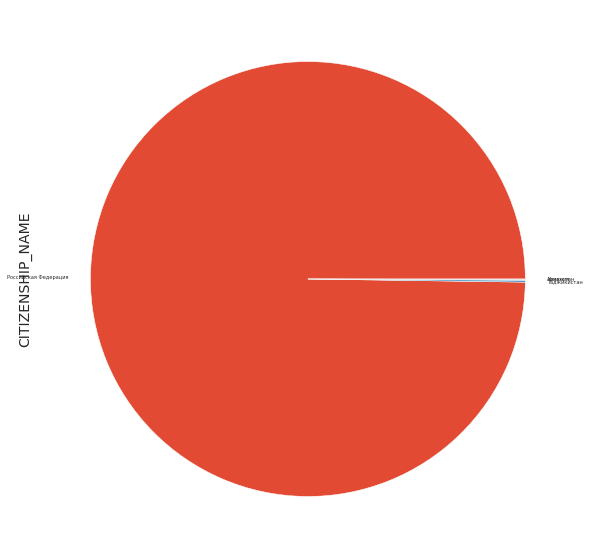

In [ ]:
(train_data["CITIZENSHIP_NAME"].value_counts(normalize = True)*100).sort_values(ascending = False).plot(kind = "pie", fontsize = 5, figsize = (10,10));

*Some variables above show one dominating category. Re-grouping the rare label in this situation does not make any sense. We could determine if these variables are useful with exploratory analysis, or any feature selection algorithm, or drop the variables altogether.*

**Variables with few categories**

In [ ]:
# let's explore examples in which variables have several categories, say more than 10

multi_cat_cols = []

for col in train_data.columns:

    if train_data[col].dtypes =='O': # if variable  is categorical
    
        if 2 < train_data[col].nunique() <= 10: # has more than 2 but less than 10 categories
            
            multi_cat_cols.append(col)  # add to the list
            
            print(train_data.groupby(col)[col].count()/ len(train_data)) # and print the percentage of observations within each category
            
            print()

CITIZENSHIP_NAME
Армения                 0.000419
Казахстан               0.000489
Российская Федерация    0.997694
Таджикистан             0.001397
Name: CITIZENSHIP_NAME, dtype: float64

OKFS_GROUP
Государственная собственность                        0.085593
Иностранная собственность                            0.031512
Смешенная российская собственность                   0.019424
Совместная российская и иностранная собственность    0.007686
Частная собственность                                0.855785
Name: OKFS_GROUP, dtype: float64

OKOPF_GROUP
Без прав юридического лица                  0.006987
Коммерческая корпоративная организация      0.912800
Коммерческая унитарная организация          0.043740
Некоммерческая корпоративная организация    0.007127
Некоммерческая унитарная организация        0.029346
Name: OKOPF_GROUP, dtype: float64

OKOGU_GROUP
Государственная власть в РФ                                       0.013904
Государственная власть в субъектах РФ                    

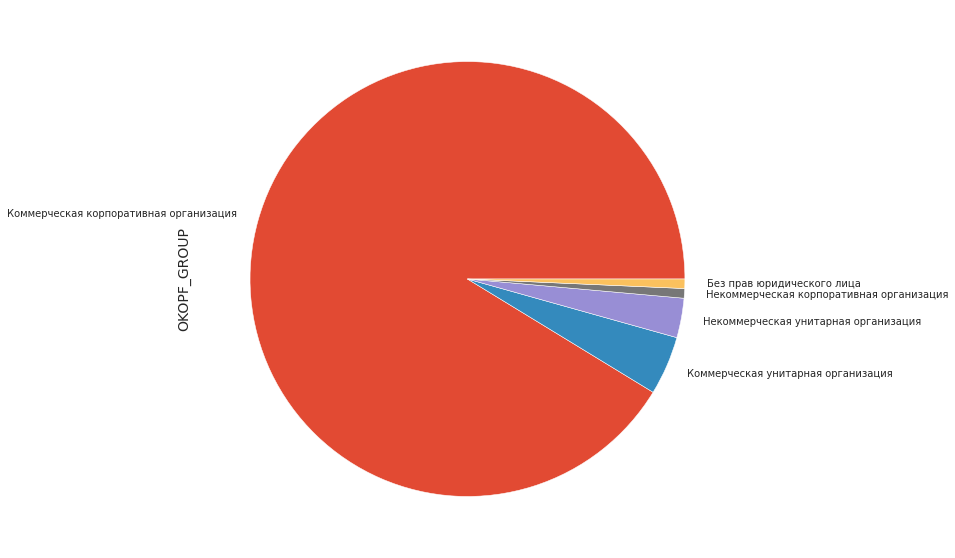

In [ ]:
(train_data["OKOPF_GROUP"].value_counts(normalize = True)*100).sort_values(ascending = False).plot(kind = "pie", fontsize = 10, figsize = (10,10));

**Variable with high cardinality**

In [ ]:
# let's explore examples in which variables have several categories, say more than 10

multi_cat_cols = []

for col in train_data.columns:

    if train_data[col].dtypes =='O': # if variable  is categorical
    
        if train_data[col].nunique() > 10: # and has more than 10 categories
            
            multi_cat_cols.append(col)  # add to the list
            
            print(train_data.groupby(col)[col].count()/ len(train_data)) # and print the percentage of observations within each category
            
            print()

OKTMO_CODE
10608414101.0    0.000070
10621101001.0    0.000070
10635442101.0    0.000070
10645410101.0    0.000070
10701000001.0    0.002515
                   ...   
98660101001.0    0.001118
98701000001.0    0.003074
99620101001.0    0.000070
99625405101.0    0.000070
99701000001.0    0.000279
Name: OKTMO_CODE, Length: 1572, dtype: float64

OKVED_CODE
01.1       0.000279
01.11      0.000140
01.11.1    0.000140
01.13      0.006778
01.13.1    0.000279
             ...   
96.02      0.000279
96.03      0.000559
96.04      0.000210
96.09      0.001258
97.00      0.000070
Name: OKVED_CODE, Length: 724, dtype: float64

OKATO_REGIONCODE
1.0     0.010201
10.0    0.003983
11.0    0.003424
12.0    0.003494
14.0    0.007895
          ...   
95.0    0.002725
96.0    0.002096
97.0    0.005101
98.0    0.005240
99.0    0.000419
Name: OKATO_REGIONCODE, Length: 83, dtype: float64

OKVED_CODE_2
01    0.010061
02    0.000559
03    0.000419
05    0.000070
06    0.000070
        ...   
93    0.002655
94 

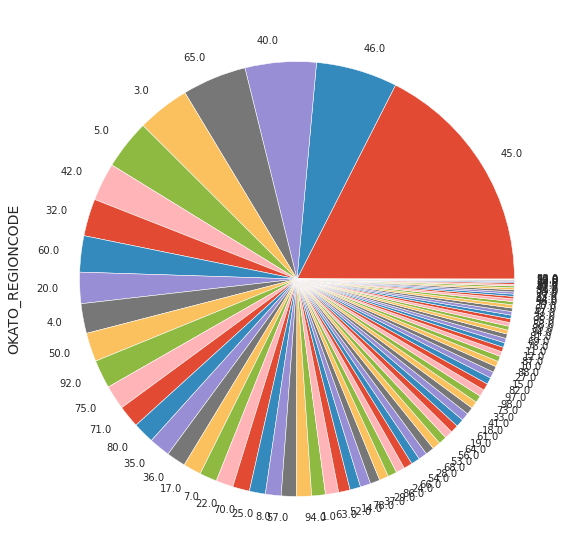

In [ ]:
(train_data["OKATO_REGIONCODE"].value_counts(normalize = True)*100).sort_values(ascending = False).plot(kind = "pie", fontsize = 10, figsize = (10,10));

## **Re-grouping rare labels**

In [ ]:
from feature_engine.encoding import RareLabelEncoder

In [ ]:
# Rare value encoder
rare_encoder = RareLabelEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=3, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=features_categorical # variables to re-group
)  

In [ ]:
rare_encoder.fit(train_data.drop(["TARGET"], axis=1))

RareLabelEncoder(n_categories=3,
                 variables=['OKTMO_CODE', 'OKVED_CODE', 'CITIZENSHIP_NAME',
                            'IP_flag', 'EGRPOINCLUDED', 'OKFS_GROUP',
                            'OKOPF_GROUP', 'OKOGU_GROUP', 'OKATO_REGIONCODE',
                            'OKATO_FED', 'OKTMO_FED', 'SEX_NAME',
                            'EGRPOINCLUDED_na', 'OKFS_GROUP_na',
                            'OKOPF_GROUP_na', 'OKOGU_GROUP_na',
                            'OKATO_REGIONCODE_na', 'OKATO_FED_na',
                            'OKTMO_CODE_na', 'OKTMO_FED_na', 'OKVED_CODE_na',
                            'THIRDOROTHERPERSON_YEAR_na',
                            'THIRDOROTHERPERSON_EVER_na', 'SEX_NAME_na',
                            'CITIZENSHIP_NAME_na', 'OKVED_CODE_2',
                            'OKVED_CODE_4', 'OKVED_CODE_5', 'OKVED_CODE_7',
                            'OKVED_CODE_8', ...])

In [ ]:
X_train = rare_encoder.transform(train_data.drop(["TARGET"], axis=1))
X_test = rare_encoder.transform(test_data)

Let's visualize changes

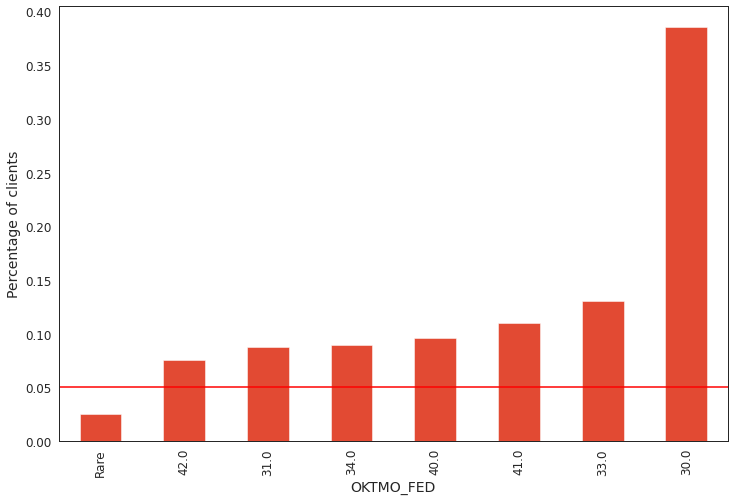

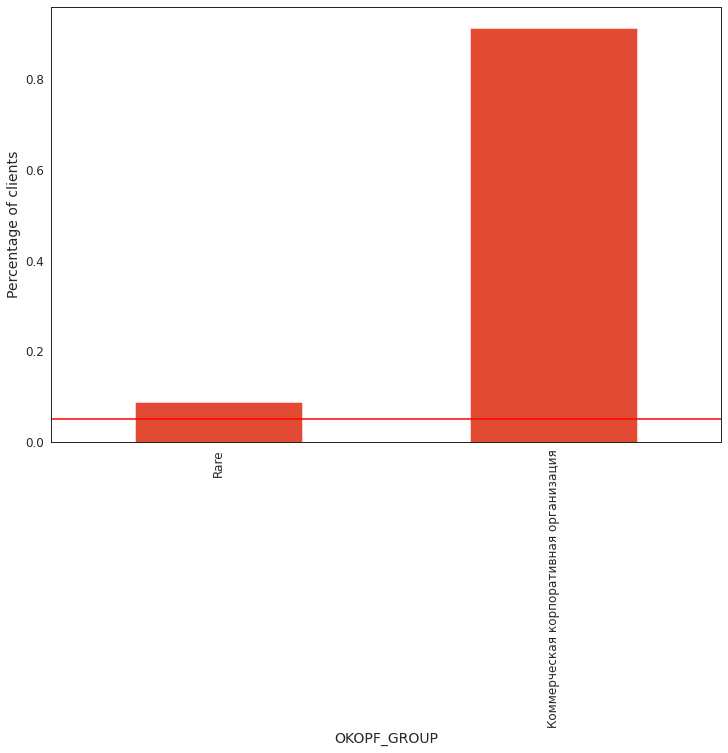

In [ ]:
for col in ['OKTMO_FED', 'OKOPF_GROUP']:

    temp_df = pd.Series((X_train[col].value_counts() / len(X_train)))

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=True).plot.bar()
    fig.set_xlabel(col)


    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of clients')
    plt.show();

As we expected rare lebels are grouped together.

## **Categorical Encoding using Count or frequency encoding** 

In count encoding we replace the categories by the count of the observations that show that category in the dataset.

The assumption of this technique is that the number observations shown by each variable is somewhat informative of the predictive power of the category.

Disadvantages

If 2 different categories appear the same amount of times in the dataset, that is, they appear in the same number of observations, they will be replaced by the same number: may lose valuable information.

In [ ]:
# to encode with feature-engine
from feature_engine.encoding import CountFrequencyEncoder

In [ ]:
count_enc = CountFrequencyEncoder(
    encoding_method='frequency',
    variables=features_categorical)

count_enc.fit(X_train)

CountFrequencyEncoder(encoding_method='frequency',
                      variables=['OKTMO_CODE', 'OKVED_CODE', 'CITIZENSHIP_NAME',
                                 'IP_flag', 'EGRPOINCLUDED', 'OKFS_GROUP',
                                 'OKOPF_GROUP', 'OKOGU_GROUP',
                                 'OKATO_REGIONCODE', 'OKATO_FED', 'OKTMO_FED',
                                 'SEX_NAME', 'EGRPOINCLUDED_na',
                                 'OKFS_GROUP_na', 'OKOPF_GROUP_na',
                                 'OKOGU_GROUP_na', 'OKATO_REGIONCODE_na',
                                 'OKATO_FED_na', 'OKTMO_CODE_na',
                                 'OKTMO_FED_na', 'OKVED_CODE_na',
                                 'THIRDOROTHERPERSON_YEAR_na',
                                 'THIRDOROTHERPERSON_EVER_na', 'SEX_NAME_na',
                                 'CITIZENSHIP_NAME_na', 'OKVED_CODE_2',
                                 'OKVED_CODE_4', 'OKVED_CODE_5', 'OKVED_CODE_7',
                  

In [ ]:
# perform encoding
X_train = count_enc.transform(X_train)
X_test = count_enc.transform(X_test)

In [ ]:
X_train["CITIZENSHIP_NAME"]

3391     0.997694
3389     0.997694
3394     0.997694
3395     0.997694
17676    0.997694
           ...   
11499    0.997694
11505    0.997694
11507    0.997694
11494    0.997694
11481    0.997694
Name: CITIZENSHIP_NAME, Length: 14312, dtype: float64

In [ ]:
# check for presence of object type columns
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14312 entries, 3391 to 11481
Columns: 375 entries, OKTMO_CODE to MANAGERINNCOUNT_std
dtypes: float64(252), int64(123)
memory usage: 41.1 MB


## Fitting with other classification algorithms

Here we will use other classification algorithms to compete with our CatBoost baseline. Additionaly we will apply Intel(R) Extension for Scikit-learn to speed up fitting time.

1) How to use

https://intel.github.io/scikit-learn-intelex/

2) Proofs of acceleration

https://www.kaggle.com/andreyrus/tps-apr-rf-with-intel-extension-for-scikit-learn/notebook

In [ ]:
# checking

print("Columns with missing values in train set:")
[feature for feature in X_train.columns if X_train.isnull().any()[feature] == True]

Columns with missing values in train set:


[]

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn(global_patch=True) # make learning a little bit faster

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # #Ensemble Methods
    # ensemble.AdaBoostClassifier(),
    # ensemble.BaggingClassifier(),
    # ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # #Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    # linear_model.PassiveAggressiveClassifier(),
    # linear_model.RidgeClassifierCV(),
    # linear_model.SGDClassifier(),
    # linear_model.Perceptron(),
    
    # #Navies Bayes
    naive_bayes.BernoulliNB(),
    # naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    # svm.NuSVC(probability=True),
    # svm.LinearSVC(),
    
    # #Trees    
    # tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # #Discriminant Analysis
    # discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    # #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%


#create table to compare MLA predictions
target = train_data["TARGET"].values.reshape((14312,1))
MLA_predict = train_data["TARGET"]

#index through MLA and save performance to table
row_index = 1
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train, target, cv  = cv_split, n_jobs = -1, scoring = "roc_auc", return_train_score=True, verbose=True) # turn on all cores
    print(f"Model {MLA_name} is trained")
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train, target)
    MLA_predict[MLA_name] = alg.predict(X_train)
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

Scikit-learn was successfully globally patched by Intel(R) Extension for Scikit-learn


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Model GradientBoostingClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.8s finished


Model RandomForestClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished


Model LogisticRegressionCV is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Model BernoulliNB is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.6s finished


Model KNeighborsClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Model SVC is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Model ExtraTreeClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.5s finished


Model XGBClassifier is trained


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
8,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.968492,0.952314,0.00912974,14.716
1,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.970201,0.95177,0.00982408,55.7132
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1,0.951526,0.00828755,9.27325
2,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1,0.95143,0.00927623,9.25612
7,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1,0.820998,0.0182916,0.13301
4,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.80347,0.797845,0.0370681,0.151544
5,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.795547,0.597343,0.042045,0.136669
6,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.625435,0.575974,0.0119753,47.3658
3,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.5,0.5,0,8.96384


In [ ]:
# save model for future usage

pickle_out = open(path_pikcle + "MLA_compare.pickle", "wb")
pickle.dump(MLA_compare, pickle_out)
pickle_out.close()

Now let's implement the same fitting without optimization

In [ ]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    # #Ensemble Methods
    # ensemble.AdaBoostClassifier(),
    # ensemble.BaggingClassifier(),
    # ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # #Gaussian Processes
    # gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    # linear_model.PassiveAggressiveClassifier(),
    # linear_model.RidgeClassifierCV(),
    # linear_model.SGDClassifier(),
    # linear_model.Perceptron(),
    
    # #Navies Bayes
    naive_bayes.BernoulliNB(),
    # naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    # svm.NuSVC(probability=True),
    # svm.LinearSVC(),
    
    # #Trees    
    # tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # #Discriminant Analysis
    # discriminant_analysis.LinearDiscriminantAnalysis(),
    # discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    # #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]


#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare_off = pd.DataFrame(columns = MLA_columns)

#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%


#create table to compare MLA predictions
target = train_data["TARGET"].values.reshape((14312,1))
MLA_predict = train_data["TARGET"]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare_off.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare_off.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train, target, cv  = cv_split, n_jobs = -1, scoring = "roc_auc", return_train_score=True, verbose=True) # turn on all cores
    print(f"Model {MLA_name} is trained")
    
    MLA_compare_off.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare_off.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare_off.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare_off.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train, target)
    MLA_predict[MLA_name] = alg.predict(X_train)
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare_off.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare_off
#MLA_predict

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


Model GradientBoostingClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished


Model RandomForestClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished


Model LogisticRegressionCV is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Model BernoulliNB is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.7s finished


Model KNeighborsClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.1min finished


Model SVC is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Model ExtraTreeClassifier is trained


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.2s finished


Model XGBClassifier is trained


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
7,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.968492,0.952314,0.00912974,14.5811
1,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1,0.951756,0.00915733,8.6173
0,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.970201,0.951745,0.00984205,56.2922
6,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1,0.825305,0.0162908,0.142987
3,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.80347,0.797845,0.0370681,0.152992
4,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.795547,0.597343,0.042045,0.0750449
5,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.626523,0.576135,0.0122204,217.648
2,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.5,0.5,0,8.82039


In [ ]:
# save model for future usage

pickle_out = open(path_pikcle + "MLA_compare_off.pickle", "wb")
pickle.dump(MLA_compare_off, pickle_out)
pickle_out.close()

Saving figure MLA_compare


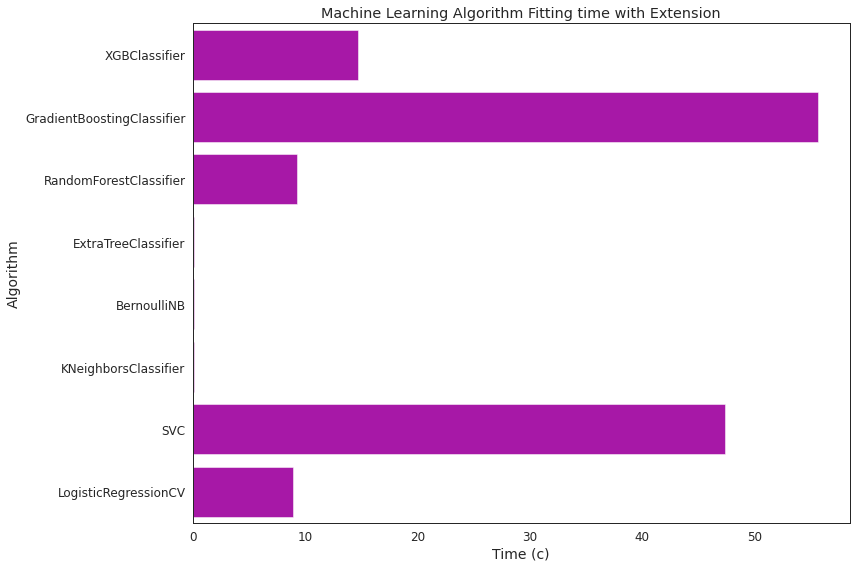

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Time', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Fitting time with Extension')
plt.xlabel('Time (c)')
plt.ylabel('Algorithm')

save_fig("MLA_compare")

Saving figure MLA_compare_off


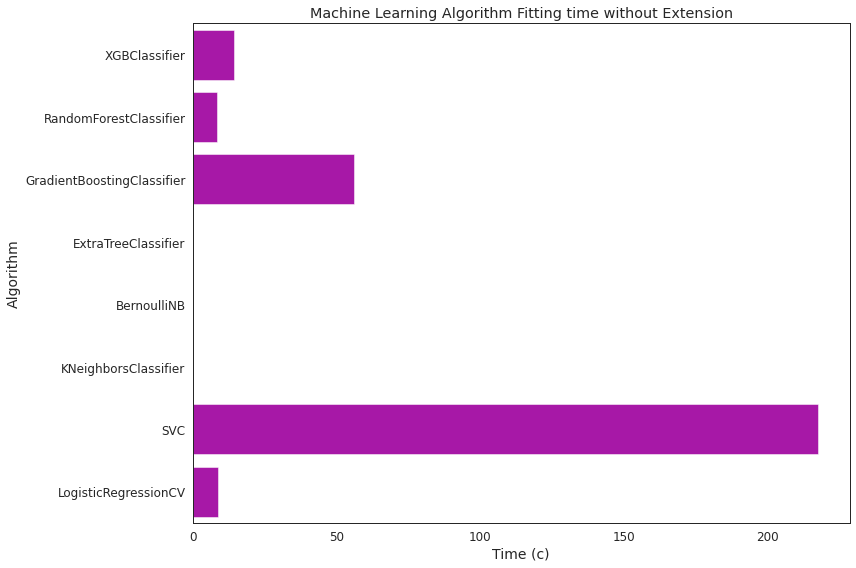

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Time', y = 'MLA Name', data = MLA_compare_off, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Fitting time without Extension')
plt.xlabel('Time (c)')
plt.ylabel('Algorithm')

save_fig("MLA_compare_off")

We see that some algorithms obtained acceleration by using Intel(R) Extension for Scikit learn. Actually, all of them should have been accelerated. Extra research will be done on that issue in the future.

## Baseline vs Other algorithms vs CatBoost

In [ ]:
pickle_in = open(path_pikcle + "cat_boost_model_first.pickle", "rb")
cat_boost_model_first = pickle.load(pickle_in)
pickle_in = open(path_pikcle + "MLA_compare.pickle", "rb")
MLA_compare = pickle.load(pickle_in)

In [ ]:
cv_cat_results = cat_boost_model_first[0][0]
fit_time = cat_boost_model_first[1]

In [ ]:
cv_cat_results["MLA Name"] = "CatBoost"
cv_cat_results["MLA Time"] = fit_time

In [ ]:
cv_cat_results = cv_cat_results.rename(columns={"test-AUC-mean":"MLA Test Accuracy Mean", "test-AUC-std":"MLA Test Accuracy 3*STD"});

In [ ]:
cv_cat_results = cv_cat_results[['MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Name', 'MLA Time']].max()

In [ ]:
MLA_compare = MLA_compare.append(cv_cat_results, ignore_index=True).sort_values(by = "MLA Test Accuracy Mean")
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
8,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.5,0.5,0,8.96384
7,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.625435,0.575974,0.0119753,47.3658
6,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.795547,0.597343,0.042045,0.136669
5,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.80347,0.797845,0.0370681,0.151544
4,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1,0.820998,0.0182916,0.13301
3,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1,0.95143,0.00927623,9.25612
2,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",1,0.951526,0.00828755,9.27325
1,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.970201,0.95177,0.00982408,55.7132
0,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.968492,0.952314,0.00912974,14.716
9,CatBoost,NaN,NaN,0.961774,0.0127084,356.066


Saving figure Compare time


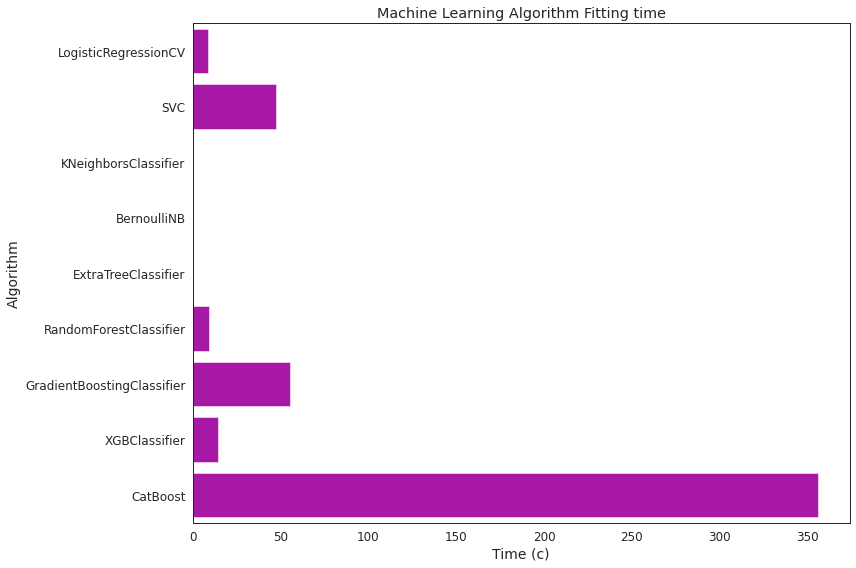

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Time', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Fitting time')
plt.xlabel('Time (c)')
plt.ylabel('Algorithm')
save_fig("Compare time")

Saving figure Compare Accuracy


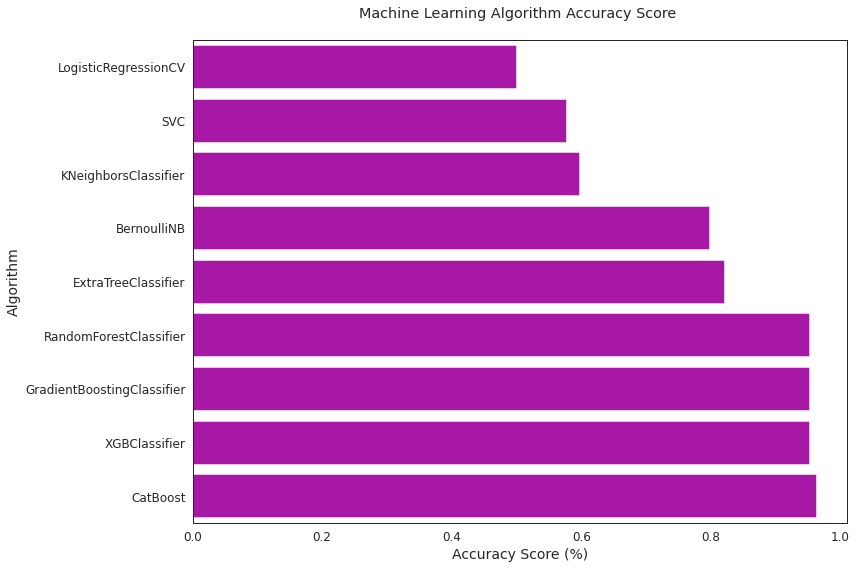

In [ ]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

save_fig("Compare Accuracy")

Obviously, CatBoost overperform little bit XGBClassifier and RandomForestClassifier in terms of test score. But Catboost is slower by almost 1000 %.

Nevetheless futher we will focus only on Catboost.

# 15) Feature selection by CatBoost

In [ ]:
# how many models we have
models = cat_boost_model_first[0][1]
models

In [ ]:
avg_table = pd.DataFrame(X_train_cat.columns, columns=["Feature Id"])

In [ ]:
# get avarage importance rate from all models
count = 0
for model in models:
  count += 1
  avg_table = avg_table.merge(model.get_feature_importance(prettified=True).rename(columns= {"Importances" : str(count)}), on = ["Feature Id"], how = "outer")

avg_table["Importances"] = (avg_table["1"] + avg_table["2"] + avg_table["3"])/len(models)

In [ ]:
feature_importance_df = avg_table[["Feature Id","Importances"]]

In [ ]:
# get top features with importance more than 0.5
feature_importance_df = feature_importance_df.loc[feature_importance_df["Importances"] > 0.5].sort_values(by = ["Importances"], ascending = False)
feature_importance_df

,Feature Id,Importances
366,F_contract_count_in_day_std,8.395313
136,Fullness,5.087640
367,F_contract_count_mean,4.972503
363,F_contract_count,3.618594
368,F_WORKERSRANGE_change_mean,3.392015
26,OKVED_CODE_4,2.446257
25,OKVED_CODE_2,2.409106
20,OKVED_CODE_na,2.253336
31,OKTMO_CODE_5,2.167454
27,OKVED_CODE_5,1.836605


Saving figure Top features


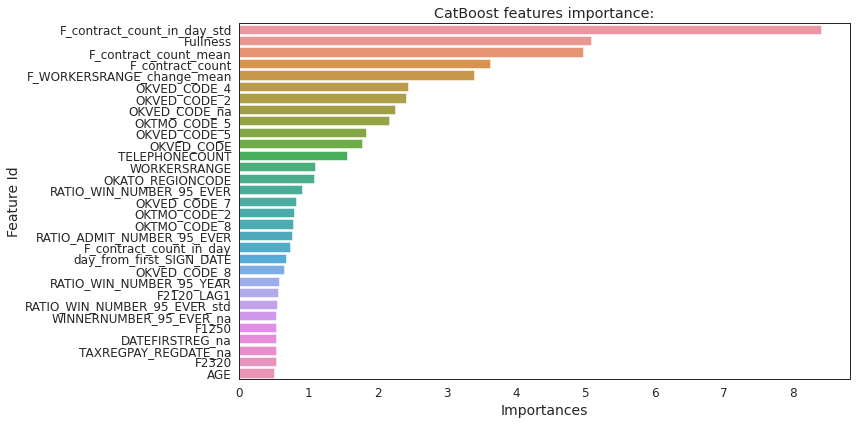

In [ ]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost features importance:');
save_fig("Top features")

In [ ]:
train_data_cat = Pool(data=X_train_cat,
                  label=y_train_cat,
                  cat_features=cat_features
                 )

In [ ]:
import shap
explainer = shap.TreeExplainer(cbc_2) # insert your model
shap_values = explainer.shap_values(train_data_cat) # insert your train Pool object

In [ ]:
shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

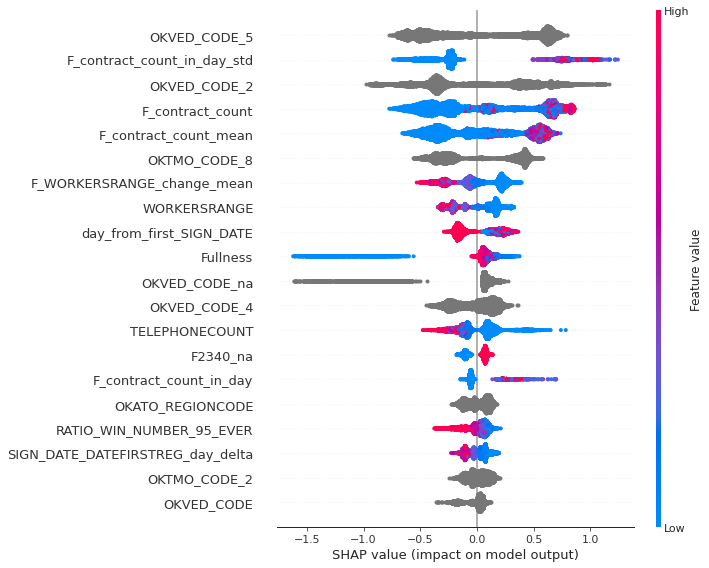

Saving figure Shap


<Figure size 864x576 with 0 Axes>

In [ ]:
shap.summary_plot(shap_values, X_train_cat)

save_fig("Shap")

On the above diagram every client (instance/row in our dataset) is represented by one dot in each row. The x position of the dot is the impact of that feature on the model’s prediction, and the color of the dot represents the value of that feature for that exact employee. Dots that do not fit on the row pile up to show density.

- Clients who sign more one contract during the day bring less risk to the bank. 
Besides, we see that clients how has little contracts also bring less risk to the bank.
- Clients who didn't report F2340 - other cost - bring more risk to the bank
- Clients who didn't report ADMITTEDNUMBER_95_YEAR - number of bid contracts - bring less risk to the bank

https://www.kaggle.com/dansbecker/shap-values

# 16) Tune Model with Hyper-Parameters (In development)

# 17) Validate and Implement

https://www.kaggle.com/bairamosmanov/tutorial-catboost-overview/edit

In [ ]:
%%time

from sklearn.model_selection import StratifiedKFold

n_fold = 4 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=SEED)

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 200,
          'random_seed': SEED
         }

test_data = Pool(data=X_test_cat,
                 cat_features=cat_features)

scores = []
prediction = np.zeros(X_test_cat.shape[0])
for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    
    train_data = Pool(data=X_train, 
                      label=y_train,
                      cat_features=cat_features)
    valid_data = Pool(data=X_valid, 
                      label=y_valid,
                      cat_features=cat_features)
    
    model = CatBoostClassifier(**params)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )
    
    score = model.get_best_score()['validation']['AUC']
    scores.append(score)

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred

prediction /= n_fold
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))

Learning rate set to 0.056952
0:	test: 0.9096506	best: 0.9096506 (0)	total: 170ms	remaining: 2m 50s
200:	test: 0.9628916	best: 0.9629541 (186)	total: 26.9s	remaining: 1m 47s
400:	test: 0.9636993	best: 0.9640322 (303)	total: 53.3s	remaining: 1m 19s
600:	test: 0.9634090	best: 0.9640322 (303)	total: 1m 19s	remaining: 52.9s
800:	test: 0.9631468	best: 0.9640322 (303)	total: 1m 46s	remaining: 26.4s
999:	test: 0.9631429	best: 0.9640322 (303)	total: 2m 12s	remaining: 0us

bestTest = 0.9640321541
bestIteration = 303

Shrink model to first 304 iterations.
Learning rate set to 0.056952
0:	test: 0.9026453	best: 0.9026453 (0)	total: 146ms	remaining: 2m 25s
200:	test: 0.9605648	best: 0.9605648 (200)	total: 27.2s	remaining: 1m 48s
400:	test: 0.9604643	best: 0.9605648 (200)	total: 53.7s	remaining: 1m 20s
600:	test: 0.9602623	best: 0.9605980 (516)	total: 1m 20s	remaining: 53.2s
800:	test: 0.9608051	best: 0.9608722 (796)	total: 1m 46s	remaining: 26.4s
999:	test: 0.9606714	best: 0.9608722 (796)	total: 2m

In [ ]:
pickle_out = open(path_pikcle + "cat_boost_model_final.pickle", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open(path_pikcle + "cat_boost_model_final.pickle", "rb")
cat_boost_model_final = pickle.load(pickle_in)

In [ ]:
X_final = X_test_cat
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3579 entries, 14312 to 17890
Columns: 375 entries, OKTMO_CODE to MANAGERINNCOUNT_std
dtypes: float64(219), int64(123), object(33)
memory usage: 10.2+ MB


In [ ]:
Y_final = list_data[1].copy()["TARGET"]
Y_final

14312    1
14313    0
14314    0
14315    1
14316    0
        ..
17886    1
17887    1
17888    1
17889    0
17890    0
Name: TARGET, Length: 3579, dtype: int64

In [ ]:
cat_boost_model_final.score(X_final, Y_final).round(4)

0.9067

**Final score on unseen test data - 0.906**

# 19) Future Research



1.   Implement imputation technic №3 to get more accuracy on prediction
2.   Use nueral networks for generating new features

